# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


Загрузка библиотек:

In [1]:
# Общие библиотеки
import os
import random
import re
from collections import Counter
from pathlib import Path

# Для работы с данными
import numpy as np
import pandas as pd

# Для работы с моделями в PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.models import ResNet18_Weights

# Для работы с текстовыми данными (BERT)
from transformers import BertTokenizer, BertModel

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Для работы с моделями машинного обучения
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Для отображения в Jupyter
from IPython.display import display, Markdown

# Дополнительные библиотеки
import textwrap

Фиксация случайности:

In [2]:
random.seed(42)
np.random.seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Загрузка данных:

In [3]:
base_path = r"C:\Users\artem\Desktop\Проект по изображениям\dsplus_integrated_project_4\to_upload"

train_dataset_path = os.path.join(base_path, "train_dataset.csv")
crowd_annotations_path = os.path.join(base_path, "CrowdAnnotations.tsv")
expert_annotations_path = os.path.join(base_path, "ExpertAnnotations.tsv")
test_queries_path = os.path.join(base_path, "test_queries.csv")
test_images_path = os.path.join(base_path, "test_images.csv")

train_df = pd.read_csv(train_dataset_path, sep=",")
crowd_df = pd.read_csv(crowd_annotations_path, sep="\t", header=None)
expert_df = pd.read_csv(expert_annotations_path, sep="\t", header=None)
test_queries_df = pd.read_csv(test_queries_path, sep="|", index_col=0)
test_images_df = pd.read_csv(test_images_path)

**Первичная оценка датасетов:**

In [4]:
def inspect_dataframe(df, name):
    display(Markdown(f"**Датасет: {name}**"))
    print(f"- Размер: {df.shape}")
    print("")
    print("- Информация:")
    print(df.info())
    print("")
    print("- Первые строки:")
    display(df.head(3))
    print("")
    print(f"- Количество дублирующихся строк: {df.duplicated().sum()}")
    print("")
    print("")

inspect_dataframe(train_df, "train_df")
inspect_dataframe(crowd_df, "crowd_df")
inspect_dataframe(expert_df, "expert_df")
inspect_dataframe(test_queries_df, "test_queries_df")
inspect_dataframe(test_images_df, "test_images_df")

**Датасет: train_df**

- Размер: (5822, 3)

- Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None

- Первые строки:


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...


- Количество дублирующихся строк: 0




**Датасет: crowd_df**

- Размер: (47830, 5)

- Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None

- Первые строки:


0                            1    2  3  4
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0  3  0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0  0  3
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0  0  3


- Количество дублирующихся строк: 0




**Датасет: expert_df**

- Размер: (5822, 5)

- Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB
None

- Первые строки:


0                            1  2  3  4
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1  1  2


- Количество дублирующихся строк: 0




**Датасет: test_queries_df**

- Размер: (500, 3)

- Информация:
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB
None

- Первые строки:


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg


- Количество дублирующихся строк: 0




**Датасет: test_images_df**

- Размер: (100, 1)

- Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes
None

- Первые строки:


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg


- Количество дублирующихся строк: 0




1. train_df (обучающая выборка):
- Содержит 3 столбца с заголовками:
  - "image" - имя файла изображения
  - "query_id" - идентификатор описания изображения
  - "query_text" - описание изображения
- Количество строк: 5822, пропусков и дубликатов нет.
- Тип данных текстовый по всем столбцам. Соответствует содержанию полей.

2. crowd_df (оценки, полученные с помощью краудсорсинга):
- Содержит 5 столбцов с заголовками:
  - "0" - имя файла изображения
  - "1" - идентификатор описания изображения
  - "2" - доля людей, подтвердивших, что описание соответствует изображению
  - "3" - количество человек, подтвердивших, что описание соответствует изображению
  - "4" - количество человек, подтвердивших, что описание не соответствует изображению
- Количество строк: 47830, пропусков и дубликатов нет.
- Тип данных текстовый, целочисленный и сплавающей точкой. Соответствует содержанию полей.

3. expert_df (оценки, полученные с помощью экспертов):
- Содержит 5 столбцов с заголовками:
  - "0" - имя файла изображения
  - "1" - идентификатор описания изображения
  - "2" - оценка первого эксперта
  - "3" - оценка второго эксперта
  - "4" - оценка третьего эксперта
- Количество строк: 5822, пропусков и дубликатов нет.
- Тип данных текстовый и целочисленный. Соответствует содержанию полей.
  
4. test_queries_df (информация для тестирования):
- Содержит 3 столбца с заголовками:
  - "image" - имя файла изображения
  - "query_id" - идентификатор описания изображения
  - "query_text" - описание изображения
- Количество строк: 500, пропусков и дубликатов нет.
- Тип данных текстовый по всем столбцам. Соответствует содержанию полей.

5. test_images_df (изображения для тестирования модели):
- Содержит 1 столбец с заголовком:
  - "image" - имя файла изображения
- Количество строк: 100, пропусков и дубликатов нет.
- Тип данных текстовый. Соответствует содержанию полей.

**Корректирующие выводы:**
1. Следует переименовать поля "0" и "1" датасетов "crowd_df" и "expert_df" таким образом, чтобы их было легко идентифицировать и логически связывать с другими таблицами:
- "0" на "image"
- "1" на "query_id"
2. Отдельно в датасете "crowd_df" для удобства понимания и отсутствия путаницы переименовать поля следующим образом:
- "2" - "share_positive"
- "3" - "count_positive"
- "4" - "count_negative"
3. Отдельно в датасете "expert_df" для удобства понимания и отсутствия путаницы переименовать поля следующим образом:
- "2" - "first_expert"
- "3" - "second_expert"
- "4" - "third_expert"

Переименуем поля:

In [5]:
crowd_df.rename(columns={
    0: "image",
    1: "query_id",
    2: "share_positive",
    3: "count_positive",
    4: "count_negative"
}, inplace=True)

expert_df.rename(columns={
    0: "image",
    1: "query_id",
    2: "first_expert",
    3: "second_expert",
    4: "third_expert"
}, inplace=True)

display(crowd_df.head(1))
display(expert_df.head(1))

image                     query_id  share_positive  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2             1.0   

   count_positive  count_negative  
0               3               0

image                     query_id  first_expert  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2             1   

   second_expert  third_expert  
0              1             1

Переименование проведено успешно.

**Проведём EDA каждого датасета:**

**- Датасет train_df**

In [6]:
def unique_values_report(df, name):
    display(Markdown(f"Анализ уникальности значений: {name}"))
    
    for col in df.columns:
        print(f"\nПоле: '{col}'")
        print(f"- Кол-во уникальных значений: {df[col].nunique()}")

unique_values_report(train_df, "train_df")

Анализ уникальности значений: train_df


Поле: 'image'
- Кол-во уникальных значений: 1000

Поле: 'query_id'
- Кол-во уникальных значений: 977

Поле: 'query_text'
- Кол-во уникальных значений: 977


В датасете train_df 5822 записей, которые распределены по 1000 фотографий. Всего описаний 977, а их количество соответвует количеству уникальных идентификаторов. Такое количество изображений, описаний и НЕ пропусков говорит о том, что одно описание может относиться сразу к нескольким изображениям.

Построим график распределения количества описаний на одно изображение из представленных:

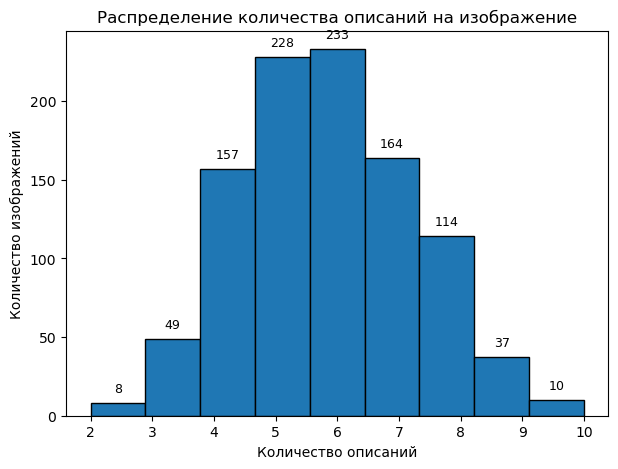

In [7]:
counts = train_df['image'].value_counts()

fig, ax = plt.subplots(figsize=(7, 5))

n, bins, patches = ax.hist(counts, bins=9, edgecolor='black')

ax.set_title("Распределение количества описаний на изображение")
ax.set_xlabel("Количество описаний")
ax.set_ylabel("Количество изображений")

for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()
    ax.text(x, y + 5, str(int(y)), ha='center', va='bottom', fontsize=9)

plt.show()

На одно изображение приходится от 2 до 10 описаний. Отметим, что в условиях проекта указано, что одному изображению может соотвествовать только 5 описаний, это может вызывать путаницу, так как мы видим, что есть изображения с более чем 5 описаниями в датасете - это связано с тем, что изображение может описываться описанием от другого изображения, что позволяет увеличить количество данных для последующей оценки экспертами и краудсорсерами.

Построим график распределения количества изображений на одно текстовое описание:

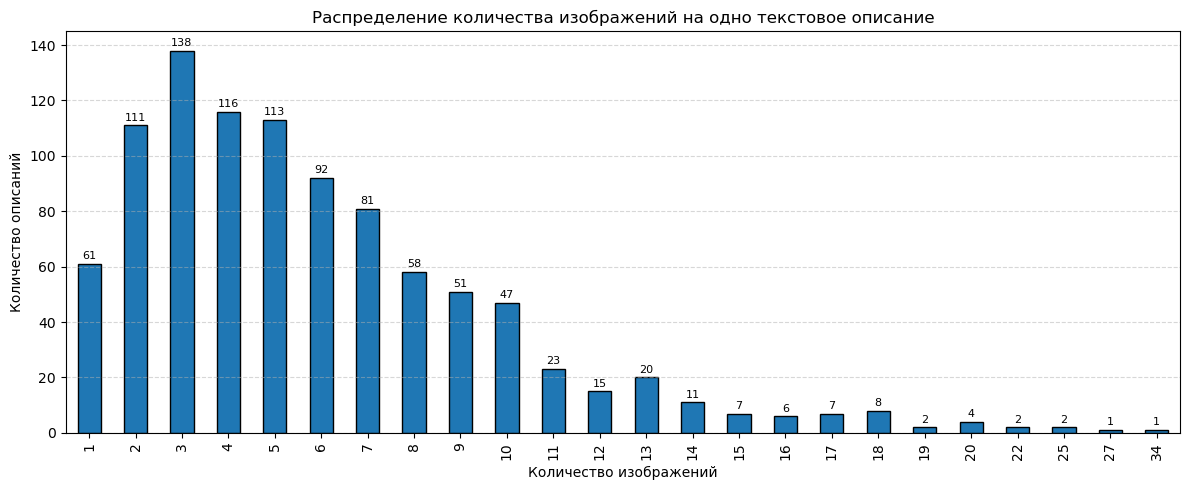

In [8]:
desc_image_counts = train_df.groupby('query_text')['image'].nunique()

desc_distribution = desc_image_counts.value_counts().sort_index()

plt.figure(figsize=(12, 5))
desc_distribution.plot(kind='bar', edgecolor='black')

plt.title("Распределение количества изображений на одно текстовое описание")
plt.xlabel("Количество изображений")
plt.ylabel("Количество описаний")

for i, value in enumerate(desc_distribution):
    plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Нет ни одного описания без изображения, но при этом только 61 описание относится только к одному изображению, а все остальные описания относятся сразу к 2 или большему количеству изображений - до 34. Чаще всего одно описание относится к трём изображениям.

Проверим наличие события "количество идентификаторов описания" относится к нескольким "описаниям":

In [9]:
unique_pairs_count = train_df[['query_id', 'query_text']].drop_duplicates().shape[0]

print("Количество уникальных пар (query_id, query_text):", unique_pairs_count)

Количество уникальных пар (query_id, query_text): 977


Поскольку уникальных значений в query_id и в query_text по отдельности составляет 977 шт., приходим к выводу, что один идентификатор никогда не относится к нескольким описаниям и наоборот.

**- Датасет crowd_df**

In [10]:
def unique_values_report(df, name):
    display(Markdown(f"Анализ уникальности значений: {name}"))
    
    for col in df.columns:
        print(f"\nПоле: '{col}'")
        print(f"- Кол-во уникальных значений: {df[col].nunique()}")

unique_values_report(crowd_df, "crowd_df")

Анализ уникальности значений: crowd_df


Поле: 'image'
- Кол-во уникальных значений: 1000

Поле: 'query_id'
- Кол-во уникальных значений: 1000

Поле: 'share_positive'
- Кол-во уникальных значений: 12

Поле: 'count_positive'
- Кол-во уникальных значений: 6

Поле: 'count_negative'
- Кол-во уникальных значений: 7


В датасете crowd_df 47830 записей, которые распределены по 1000 фотографий. Всего уникальных идентификаторов описаний 1000. Представлено 12 уникальных значений "доля людей, подтвердивших, что описание соответствует изображению", 6 уникальных значений "количество человек, подтвердивших, что описание соответствует изображению"", 7 уникальных значений "количество человек, подтвердивших, что описание не соответствует изображению".

Оценим уникальные значения и распределение поля share_positive:

In [11]:
share_counts = crowd_df['share_positive'].value_counts().sort_index()
display(share_counts)

share_positive
0.000000    41970
0.166667        3
0.200000       22
0.250000       96
0.333333     3000
0.400000        8
0.500000       27
0.600000        8
0.666667     1360
0.750000        9
0.800000        4
1.000000     1323
Name: count, dtype: int64

Уникальные значения адекватны. Наиболее распространена нулевая доля людей, подтвердивших, что описание соответствует изображению (41970 шт.). На втором месте по распределению доля 0.33 (3000 шт.). На третьем месте доля - 0.66 (1360 шт.). На четвертом месте - 1 (1323 шт.). Остальные значения встречаются крайне редко.

Оценим уникальные значения поля count_positive:

In [12]:
share_counts = crowd_df['count_positive'].value_counts().sort_index()
display(share_counts)

count_positive
0    41970
1     3119
2     1394
3     1328
4       14
5        5
Name: count, dtype: int64

Уникальные значения адекватны. Количество человек, подтвердивших, что описание соответствует изображению равное 0 чел. составило 41970, равное 1 чел. - 3119, равное 2 чел. - 1394, равное 3 чел. - 1328, равное 4 чел. - 14, равное 5 чел. - 5.

Оценим уникальные значения поля count_negative:

In [13]:
share_counts = crowd_df['count_negative'].value_counts().sort_index()
display(share_counts)

count_negative
0     1323
1     1371
2     3034
3    41219
4      665
5      176
6       42
Name: count, dtype: int64

Уникальные значения адекватны. Количество человек, подтвердивших, что описание не соответствует изображению равное 0 чел. составило 1323, равное 1 чел. - 1371, равное 3 чел. - 31219, равное 4 чел. - 665, равное 5 чел. - 176, равное 6 чел. - 42.

Оценим общее количество совпадающих изображений между датасетами "crowd_df" и "train_df":

In [14]:
common_images_count = len(set(train_df['image']).intersection(set(crowd_df['image'])))
common_images_count

1000

Таким образом, наборы фотографий полностью совпадают.

Оценим общее количество совпадающих идентфиикаторов описаний между датасетами "crowd_df" и "train_df":

In [15]:
common_query_id_count = len(set(train_df['query_id']).intersection(set(crowd_df['query_id'])))
common_query_id_count

977

Таким образом, наборы идентификаторов совпадают в той мере, в какой это возможно (в датасете train_df всего 977 идентификаторов описаний).

**- Датасет expert_df**

In [16]:
def unique_values_report(df, name):
    display(Markdown(f"Анализ уникальности значений: {name}"))
    
    for col in df.columns:
        print(f"\nПоле: '{col}'")
        print(f"- Кол-во уникальных значений: {df[col].nunique()}")

unique_values_report(expert_df, "expert_df")

Анализ уникальности значений: expert_df


Поле: 'image'
- Кол-во уникальных значений: 1000

Поле: 'query_id'
- Кол-во уникальных значений: 977

Поле: 'first_expert'
- Кол-во уникальных значений: 4

Поле: 'second_expert'
- Кол-во уникальных значений: 4

Поле: 'third_expert'
- Кол-во уникальных значений: 4


В датасете expert_df 5822 записей, которые распределены по 1000 фотографий. Всего уникальных идентификаторов описаний 977. Представлено 4 уникальных значения "оценка первого эксперта", 4 уникальных значения "оценка второго эксперта", 4 уникальных значений "оценка третьего эксперта".

Оценим уникальные значения и распределение поля first_expert:

In [17]:
first_expert_counts = expert_df['first_expert'].value_counts().sort_index()
display(first_expert_counts)

first_expert
1    4120
2    1109
3     346
4     247
Name: count, dtype: int64

Уникальные значения адекватны. Количество оценок "1", выставленных первым экспертом, составило 4120 шт., "2" - 1109 шт., "3" - 346 шт., "4" - 247 шт.

Оценим уникальные значения и распределение поля second_expert:

In [18]:
second_expert_counts = expert_df['second_expert'].value_counts().sort_index()
display(second_expert_counts)

second_expert
1    3327
2    1666
3     518
4     311
Name: count, dtype: int64

Уникальные значения адекватны. Количество оценок "1", выставленных вторым экспертом, составило 3327 шт., "2" - 1666 шт., "3" - 518 шт., "4" - 311 шт.

Оценим уникальные значения и распределение поля third_expert:

In [19]:
third_expert_counts = expert_df['third_expert'].value_counts().sort_index()
display(third_expert_counts)

third_expert
1    2350
2    2222
3     837
4     413
Name: count, dtype: int64

Уникальные значения адекватны. Количество оценок "1", выставленных третьим экспертом, составило 2350 шт., "2" - 2222 шт., "3" - 837 шт., "4" - 413 шт.

Оценим общее количество совпадающих изображений между датасетами "expert_df" и "train_df":

In [20]:
common_images_count = len(set(train_df['image']).intersection(set(expert_df['image'])))
common_images_count

1000

Таким образом, наборы фотографий полностью совпадают.

Оценим общее количество совпадающих идентфиикаторов описаний между датасетами "expert_df" и "train_df":

In [21]:
common_query_id_count = len(set(train_df['query_id']).intersection(set(expert_df['query_id'])))
common_query_id_count

977

Таким образом, наборы идентификаторов полностью совпадают.

**- Датасет test_queries_df**

In [22]:
def unique_values_report(df, name):
    display(Markdown(f"Анализ уникальности значений: {name}"))
    
    for col in df.columns:
        print(f"\nПоле: '{col}'")
        print(f"- Кол-во уникальных значений: {df[col].nunique()}")

unique_values_report(test_queries_df, "test_queries_df")

Анализ уникальности значений: test_queries_df


Поле: 'query_id'
- Кол-во уникальных значений: 500

Поле: 'query_text'
- Кол-во уникальных значений: 500

Поле: 'image'
- Кол-во уникальных значений: 100


В датасете test_queries_df 500 записей, которые распределены по 100 фотографиям. Всего описаний 500, а их количество соответвует количеству уникальных идентификаторов. Такое количество изображений, описаний и НЕ пропусков говорит о том, что одно описание может относиться сразу к нескольким изображениям.

Построим график распределения количества описаний на одно изображение из представленных:

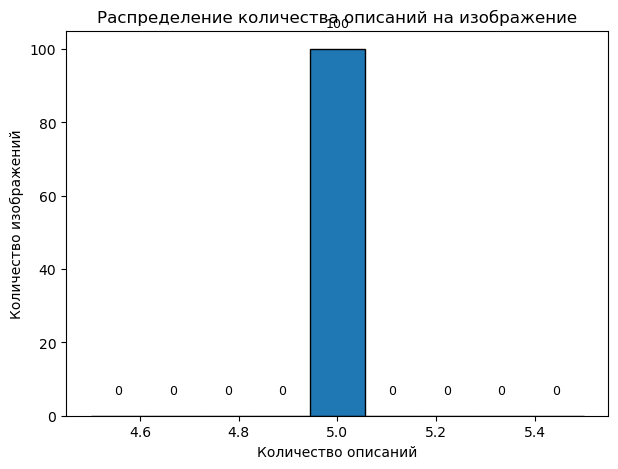

In [23]:
counts = test_queries_df['image'].value_counts()

fig, ax = plt.subplots(figsize=(7, 5))

n, bins, patches = ax.hist(counts, bins=9, edgecolor='black')

ax.set_title("Распределение количества описаний на изображение")
ax.set_xlabel("Количество описаний")
ax.set_ylabel("Количество изображений")

for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()
    ax.text(x, y + 5, str(int(y)), ha='center', va='bottom', fontsize=9)

plt.show()

На одно каждое изображение в датасете приходится 5 описаний.

Построим график распределения количества изображений на одно текстовое описание:

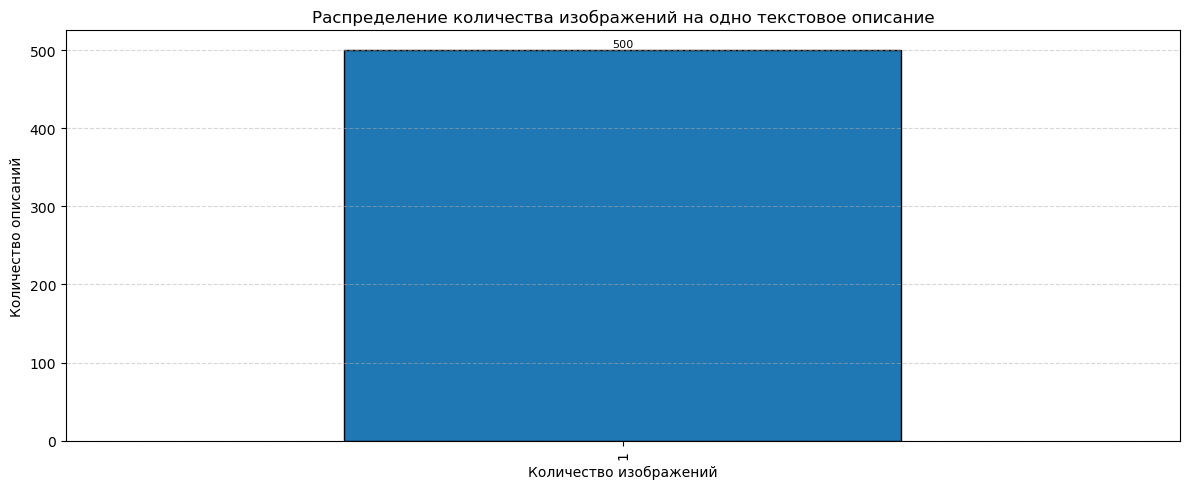

In [24]:
desc_image_counts = test_queries_df.groupby('query_text')['image'].nunique()

desc_distribution = desc_image_counts.value_counts().sort_index()

plt.figure(figsize=(12, 5))
desc_distribution.plot(kind='bar', edgecolor='black')

plt.title("Распределение количества изображений на одно текстовое описание")
plt.xlabel("Количество изображений")
plt.ylabel("Количество описаний")

for i, value in enumerate(desc_distribution):
    plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

На каждое описание приходится только одно изображение.

Оценим общее количество совпадающих изображений между датасетами "test_queries_df" и "train_df":

In [25]:
common_images_count = len(set(train_df['image']).intersection(set(test_queries_df['image'])))
common_images_count

0

Оценим общее количество совпадающих идентификаторов описаний между датасетами "test_queries_df" и "train_df":

In [26]:
common_images_count = len(set(train_df['query_id']).intersection(set(test_queries_df['query_id'])))
common_images_count

0

Ни одно изображение из датасета "test_queries_df" не входит в датасет "train_df", значит и в датасеты "crowd_df", "expert_df". 

**- Датасет test_images_df**

In [27]:
def unique_values_report(df, name):
    display(Markdown(f"Анализ уникальности значений: {name}"))
    
    for col in df.columns:
        print(f"\nПоле: '{col}'")
        print(f"- Кол-во уникальных значений: {df[col].nunique()}")

unique_values_report(test_images_df, "test_images_df")

Анализ уникальности значений: test_images_df


Поле: 'image'
- Кол-во уникальных значений: 100


Оценим общее количество совпадающих изображений между датасетами "test_images_df" и "test_queries_df":

In [28]:
common_images_count = len(set(test_images_df['image']).intersection(set(test_queries_df['image'])))
common_images_count

100

Все изображения в датасетах совпадают.

Выведем изображения из датасетов "train_df" и "test_images_df":

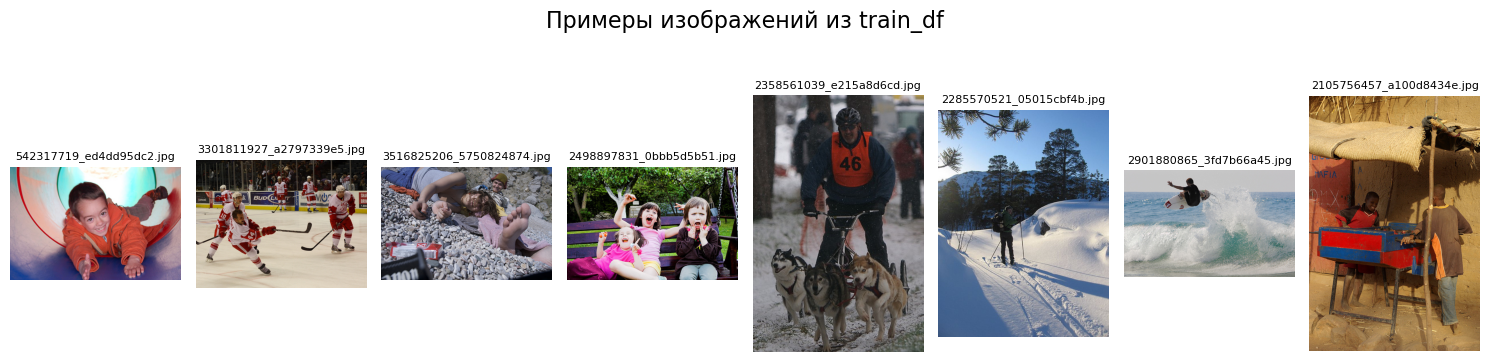

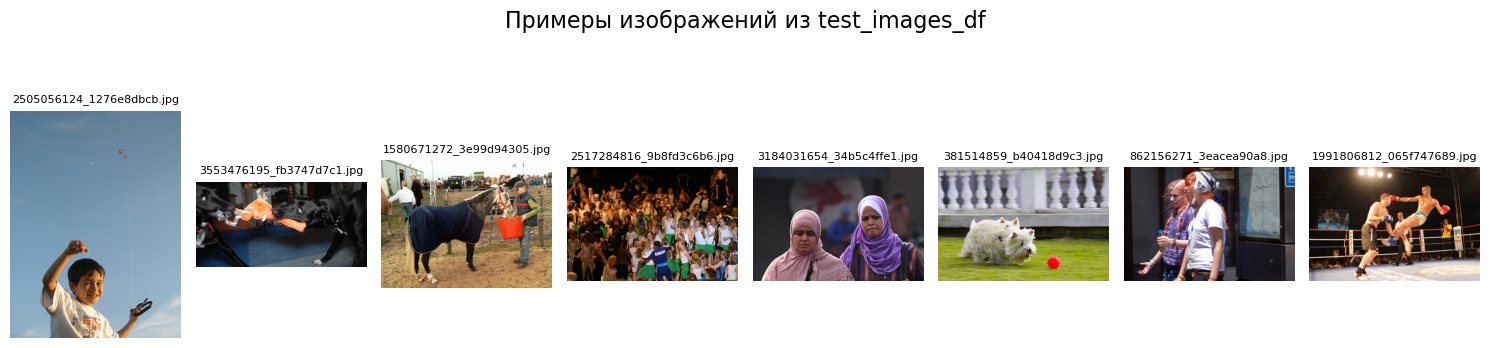

In [29]:
train_images_path = os.path.join(base_path, 'train_images')
test_images_path = os.path.join(base_path, 'test_images')

def show_images(df, image_column, images_path, title, n=8):
    sample_images = df[image_column].dropna().sample(n, random_state=42).tolist()

    fig, axes = plt.subplots(1, n, figsize=(15, 4))
    fig.suptitle(title, fontsize=16)

    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(images_path, image_name)
        image = Image.open(image_path)

        axes[i].imshow(image)
        axes[i].set_title(f"{image_name}", fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

show_images(train_df, image_column='image', images_path=train_images_path, title="Примеры изображений из train_df")

show_images(test_images_df, image_column='image', images_path=test_images_path, title="Примеры изображений из test_images_df")

На изображениях замечены дети, хотя по условиям проекта требуется, чтобы данный контент не был показан. Позже данный момент будет отдельно реализован в решении.

**Агрегация оценок:**

1. Краудсорсинговые оценки мы не используем, потому что они поверхностны и часто неточны. Экспертные оценки обладают высоким качеством и шкалой градации, что позволяет модели точнее учитывать степень соответствия текста и изображения.

2. В случае если все три экспертные оценки отличаются друг от друга, предлагается такую оценку не учитывать. Это связано с тем, что мы не можем однозначно принять решение относительно соответствия изображения и описания. Подсчитаем количество таких случаев:

In [30]:
def is_all_different(row):
    votes = [row['first_expert'], row['second_expert'], row['third_expert']]
    return len(Counter(votes)) == 3

num_all_different = expert_df.apply(is_all_different, axis=1).sum()
total = len(expert_df)

print(f"Количество пар с тремя разными оценками: {num_all_different} из {total} ({num_all_different/total:.2%})")

Количество пар с тремя разными оценками: 126 из 5822 (2.16%)


Доля различающихся оценок не высока, поэтому данный подход допустим.

Вычислим итоговую оценку в диапазоне от 0 до 1 в соответствии с условиями проекта:

In [31]:
def majority_vote(row):
    votes = [row['first_expert'], row['second_expert'], row['third_expert']]
    counts = Counter(votes)
    most_common = counts.most_common(1)[0]
    
    if len(counts) == 3:
        return None
    return most_common[0]

expert_df['expert_majority'] = expert_df.apply(majority_vote, axis=1)

expert_df = expert_df[expert_df['expert_majority'].notnull()].copy()

expert_df['final_score'] = (expert_df['expert_majority'] - 1) / 3

display(expert_df[['image', 'query_id', 'first_expert', 'second_expert', 'third_expert', 'expert_majority', 'final_score']].head())

print(f"Количество итоговых пар: {len(expert_df)}")
print("Распределение оценок:")
display(expert_df['expert_majority'].value_counts().sort_index())

image                     query_id  first_expert  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2             1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2             1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2             1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2             1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2             1   

   second_expert  third_expert  expert_majority  final_score  
0              1             1              1.0     0.000000  
1              1             2              1.0     0.000000  
2              1             2              1.0     0.000000  
3              2             2              2.0     0.333333  
4              1             2              1.0     0.000000

Количество итоговых пар: 5696
Распределение оценок:


expert_majority
1.0    3327
2.0    1566
3.0     492
4.0     311
Name: count, dtype: int64

Оценим распределение итоговых нормализованных оценок:

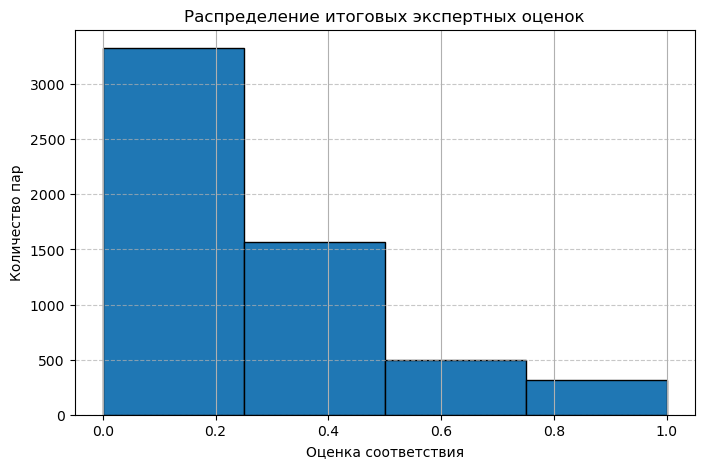

In [32]:
plt.figure(figsize=(8, 5))
expert_df['final_score'].hist(bins=4, edgecolor='black')
plt.title("Распределение итоговых экспертных оценок")
plt.xlabel("Оценка соответствия")
plt.ylabel("Количество пар")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Удалим лишние поля:

In [33]:
expert_df.drop(columns=['first_expert', 'second_expert', 'third_expert', 'expert_majority'], inplace=True)

Проверим датасет:

In [34]:
expert_df

image                     query_id  final_score
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.000000
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     0.000000
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     0.000000
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     0.333333
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     0.000000
...                         ...                          ...          ...
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2     0.000000
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2     0.000000
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2     0.000000
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     0.000000
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     0.666667

[5696 rows x 3 columns]

Объединим датасеты expert_df и train_df:

In [35]:
merged_df = pd.merge(expert_df, train_df, on=['image', 'query_id'], how='inner')

Проверим:

In [36]:
merged_df

image                     query_id  final_score  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.000000   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     0.000000   
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     0.000000   
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     0.333333   
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     0.000000   
...                         ...                          ...          ...   
5691   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2     0.000000   
5692   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2     0.000000   
5693   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2     0.000000   
5694   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     0.000000   
5695   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     0.666667   

                                             query_text  
0     A young child is wearing blue goggles and sitt...  
1     A girl wearing a yellow shirt and sunglasses s...  
2       A man sleeps under a blanket on a city street .  
3     A woman plays with long red ribbons in an empt...  
4            Chinese market street in the winter time .  
...                                                 ...  
5691  People trackside at a subway station by a train .  
5692                        A man sitting on a subway .  
5693  A man wearing a red hat looks down as another ...  
5694         A white birds lands swiftly in the water .  
5695       A person wearing a white hat climbs a rock .  

[5696 rows x 4 columns]

Оценим частоту употребления слов в описаниях тренировочного датасета:

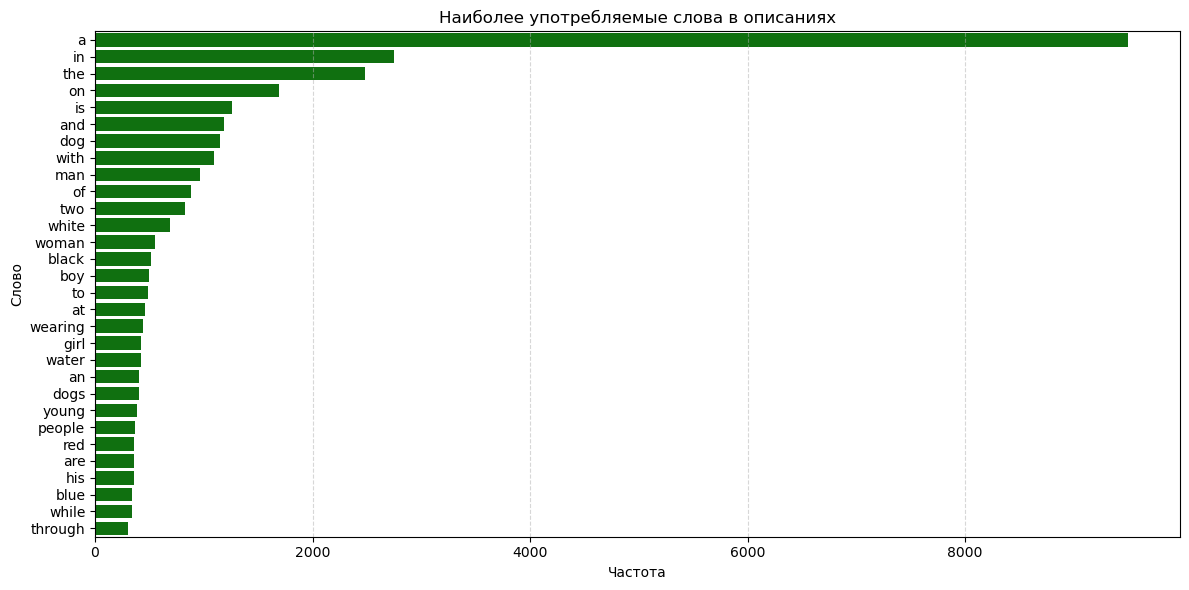

In [37]:
def most_common_words(text_series, top_n=30):
    words = text_series.str.lower().str.replace(r"[^\w\s]", " ", regex=True).str.split()
    flat_words = [word for sublist in words for word in sublist if word.strip()]
    
    word_counts = Counter(flat_words)
    return word_counts.most_common(top_n)

def plot_word_frequency(words_df, title="Частота употребления слов", color='green'):
    plt.figure(figsize=(12, 6))
    sns.barplot(x="count", y="word", data=words_df, color=color)
    plt.title(title)
    plt.xlabel("Частота")
    plt.ylabel("Слово")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

word_freq = pd.DataFrame(most_common_words(merged_df['query_text']), columns=['word', 'count'])

word_freq = word_freq[word_freq['word'] != '']

plot_word_frequency(word_freq, title="Наиболее употребляемые слова в описаниях", color='green')

В число наиболее употребляемых слов вошли такие слова как "boy", "girl", "young", которые являются описанием молодых людей и должны войти в перечень стоп-слов в соответствии с задачей по соблюдению юридических ограничений. При этом наиболее распространенными оказались всяческие предлоги, союзы, а также такие слова как "dog", "man", "white", "woman".

**Промежуточные выводы:** <br>
1.	В рамках проекта загружены 5 датасетов:
- train_df (файл train_dataset.csv) – основной обучающий датасет, содержащий пары изображение-описание. Каждая запись включает имя файла изображения (image), идентификатор описания (query_id) и сам текст (query_text).
- crowd_df (файл CrowdAnnotations.tsv) – датасет с краудсорсинговыми оценками соответствия описания изображению. Содержит имя изображения (image), идентификатор описания (query_id), долю положительных голосов (share_positive), число положительных (count_positive) и отрицательных (count_negative) ответов. Столбцы датасета изначально были названы «0», «1», «2», «3», «4», но для удобства были переименованы.
- expert_df (файл ExpertAnnotations.tsv) – датасет с экспертными оценками соответствия описания изображению. Содержит имя изображения (image), идентификатор описания (query_id), а также оценку первого эксперта (first_expert), второго эксперта (second_expert) и третьего эксперта (third_expert). Столбцы датасета изначально были названы «0», «1», «2», «3», «4», но для удобства были переименованы.
- test_queries_df (файл test_queries.csv) – тестовый датасет, содержащий содержащий пары изображение-описание. Каждая запись включает имя файла изображения (image), идентификатор описания (query_id) и сам текст (query_text).
- test_images_df (файл test_images.csv) – тестовый датасет, содержащий список всех имён файлов изображений (image).
2. В рамках проекта представлены две папки с изображениями в формате jpg:
- train_images – 1000 изображений для обучения модели.
- test_images – 100 изображений для тестирования модели.
3. Проведена оценка датасетов:
- train_df: <br>
  -- 5822 записи <br>
  -- отсутствуют пропуски и дубликаты <br>
  -- тип данных подходящий <br>
  -- всего в датасете 1000 уникальных имен изображений, которым соответствует 977 уникальных описания <br>
  -- на одно изображение приходится от 2 до 10 описаний, при этом в условиях проекта указано, что одному изображению может соотвествовать только 5 описаний, это может вызывать путаницу, так как мы видим, что есть изображения с более чем 5 описаниями в датасете - это связано с тем, что изображение может описываться описанием от другого изображения, что позволяет увеличить количество данных для последующей оценки экспертами и краудсорсерами <br>
  -- одно описание может быть использовано для нескольких изображений – чаще всего одно описание используется 3 раза, при этом лишь 61 описание относится лишь к одному изображению, среди описаний есть одно, которое относится к максимальному количеству изображений – 34 шт.
- crowd_df: <br>
  -- 47830 записи <br>
  -- отсутствуют пропуски и дубликаты <br>
  -- типы данных подходящие <br>
  -- всего в датасете 1000 уникальных имен изображений, которым соответствует 1000 уникальных идентификатора описания <br>
  -- по полю «share_positive», которое описывает долю людей, подтвердивших, что описание соответствует изображению, всего 12 уникальных значений в диапазоне от 0 до 1, наиболее распространена нулевая доля (41970 шт.), затем доля 0.33 (3000 шт.), затем – 0.66 (1360 шт.),  далее – 1 (1323 шт.), остальные значения встречаются крайне редко <br>
  -- по полю «count_positive», которое описывает количество человек, подтвердивших, что описание соответствует изображению, всего 6 уникальных значений от 0 до 5 чел. (0 чел. составило 41970, равное 1 чел. - 3119, равное 2 чел. - 1394, равное 3 чел. - 1328, равное 4 чел. - 14, равное 5 чел. - 5) <br>
  -- по полю «count_negative», которое описывает количество человек, подтвердивших, что описание не соответствует изображению, всего 7 уникальных значений от 0 до 6 чел. (0 чел. составило 1323, равное 1 чел. - 1371, равное 3 чел. - 31219, равное 4 чел. - 665, равное 5 чел. - 176, равное 6 чел. - 42)
- expert_df: <br>
  -- 5822 записи <br>
  -- отсутствуют пропуски и дубликаты <br>
  -- тип данных подходящий <br>
  -- всего в датасете 1000 уникальных имен изображений, которым соответствует 977 уникальных идентификатора описания <br>
  -- по полю «first_expert», которое описывает оценки первого эксперта, всего 4 уникальных значения в диапазоне от 0 до 4, где 1 – изображение и запрос совершенно не соответствуют друг другу, 2 – запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 – запрос и текст соответствуют с точностью до некоторых деталей, 4 – запрос и текст соответствуют полностью; оценки распределены следующим образом: 1 – 4120 шт., 2 – 1109 шт., 3 – 346 шт., 4 – 247 шт. <br>
  -- по полю «second_expert», которое описывает оценки второго эксперта, всего 4 уникальных значения в диапазоне от 0 до 4, имеющих то же значение, что и у первого эксперта; оценки распределены следующим образом: 1 – 3327 шт., 2 – 1666 шт., 3 – 518 шт., 4 – 311 шт. <br>
  -- по полю «third_expert», которое описывает оценки третьего эксперта, всего 4 уникальных значения в диапазоне от 0 до 4, имеющих то же значение, что и у первых экспертов; оценки распределены следующим образом: 1 – 2350 шт., 2 – 2222 шт., 3 – 837 шт., 4 – 413 шт. <br>
  -- заметно, что в основном эксперты голосуют за «несоответствие» изображения и описания
- test_queries_df: <br>
  -- 500 записей <br>
  -- отсутствуют пропуски и дубликаты <br>
  -- тип данных подходящий <br>
  -- всего в датасете 100 уникальных имен изображений, которым соответствует 500 уникальных идентификаторов описания, т.е. по 5 шт. на одно изображение
- test_images_df: <br>
  -- 100 записей <br>
  -- отсутствуют пропуски и дубликаты <br>
  -- тип данных подходящий
4. Проведена отдельная оценка соответствия полей image и query_id между всеми датасетами, которая подтвердила, что все датасеты работают с одинаковым набором изображений и текстовых описаний (отдельно тренировочные и тестовые данные, т.е. утечки данных нет).
5. Краудсорсинговых оценок больше, но они менее качественные. Экспертные оценки обладают высоким качеством и шкалой градации, что позволяет модели точнее учитывать степень соответствия текста и изображения. В этой связи предлагается использовать в модели исключительно оценки экспертов.
6. Была проведена агрегация оценок экспертов из трёх в одну по каждой записи, для этого использовался следующий подход: если среди оценок две или три повторяются, то итоговая оценка равна повторяющимся, если же все три экспертные оценки отличаются друг от друга, предлагается такую оценку не учитывать. Из 5822 записей только 2,16% (126 записей) состояли из трех разных оценок – они были удалены.
7. По условиям проекта модель должна предсказать значение от 0 до 1, которая будет вероятностью соответствия текстового описания и изображения, поэтому агрегированные оценки датасета expert_df были приведены к  диапазону от 0 до 1, по следующему правилу: оценка 1 – это 0, оценка 2 – это 0.33, оценка 3 – это 0.66, оценка 4 – это 1. Лишние поля были удалены (first_expert, second_expert, third_expert, expert_majority). Распределение значений оказалось следующим: 0 – 3327 шт., 0.33 – 1566 шт., 0.66 – 492 шт., 1 – 311 шт. Как уже было указано ранее, основном эксперты голосуют за несоответствие изображения и текстового описания. Итого в датасете «expert_df» 5696 записей.
8. Датасеты «expert_df» и «train_df» были объединены под именем «merged_df», в результате чего образовался датасет с 5696 записей и полями «image», «query_id», «query_text», «final_score».
9. Была оценена частота употребления слов в образованном датасете «merged_df»: в число наиболее употребляемых слов вошли такие слова как «boy», «girl», «young», которые являются явным описанием молодых людей, при этом наиболее распространенными оказались всяческие предлоги, союзы, а также такие слова как «dog», «man», «white», «woman».

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

**Сформируем список стоп-слов в соответствии с задачей по соблюдению юридических ограничений (учтём множественное число слов):**

In [38]:
blocklist_keywords = [
    "boy", "boys",
    "girl", "girls",
    "young",
    "child", "children",
    "kid", "kids",
    "toddler", "toddlers",
    "baby", "babies",
    "infant", "infants",
    "newborn", "newborns",
    "teen", "teens",
    "teenager", "teenagers",
    "schoolboy", "schoolboys",
    "schoolgirl", "schoolgirls",
    "pupil", "pupils",
    "minor", "minors",
    "juvenile", "juveniles",
    "nursery", "nurseries",
    "diaper", "diapers",
    "pacifier", "pacifiers",
    "playground", "playgrounds"
]

Оценим описания со стоп словами:

Записей к удалению (по блокирующим словам и оценке > 0.5): 138
Из общего числа записей: 5696 (2.42% от датасета)


image  \
50   1131932671_c8d17751b3.jpg   
51   1131932671_c8d17751b3.jpg   
74   1174525839_7c1e6cfa86.jpg   
75   1174525839_7c1e6cfa86.jpg   
166  1298295313_db1f4c6522.jpg   
168  1298295313_db1f4c6522.jpg   
183  1322323208_c7ecb742c6.jpg   
253   136644343_0e2b423829.jpg   
301  1402640441_81978e32a9.jpg   
315  1408958345_68eea9a4e4.jpg   

                                            query_text  final_score  
50               A boy jumps from one bed to another .     1.000000  
51                 A child jumping on a tennis court .     0.666667  
74                  a little girl kicks into the air .     0.666667  
75   A little girl runs on the wet sand near the oc...     0.666667  
166             a boy jumps into the blue pool water .     0.666667  
168            A boy is about to jump into the water .     0.666667  
183  Two children , one of which is holding a stick...     1.000000  
253  A boy smiling , leaning over a wagon filled wi...     0.666667  
301                          A boy plays in the sand .     1.000000  
315    Two kids playing on a pebble beach by the water     0.666667

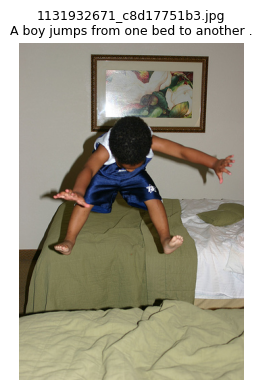

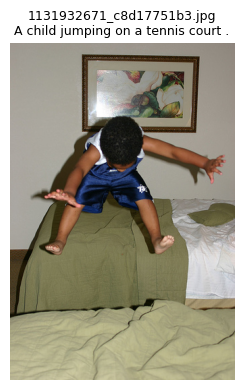

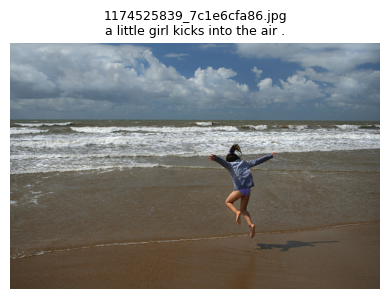

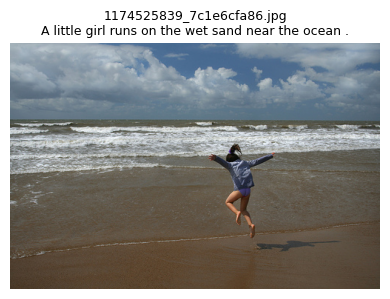

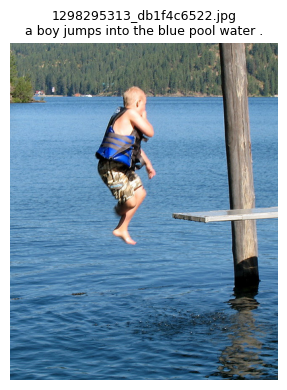

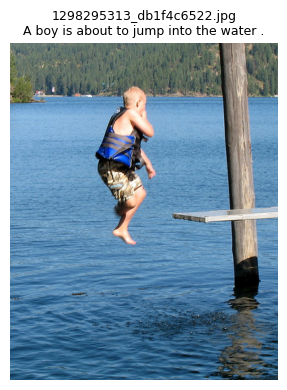

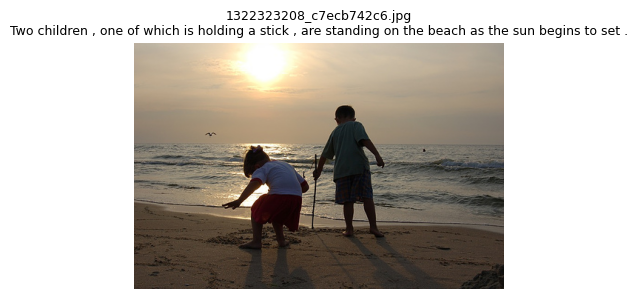

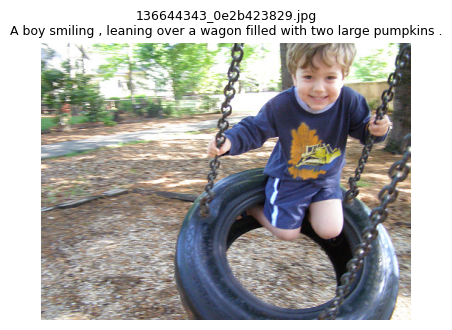

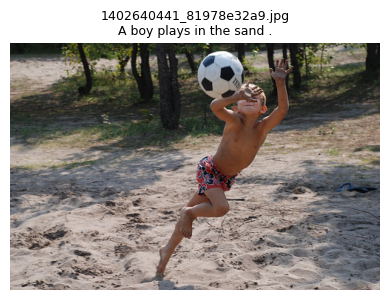

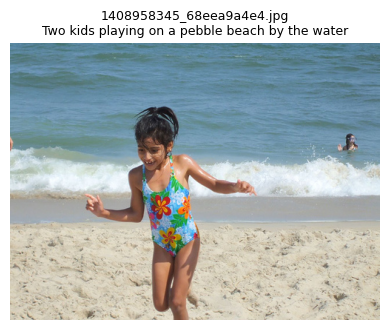

In [39]:
pattern = re.compile(r'\b(' + '|'.join(blocklist_keywords) + r')\b', flags=re.IGNORECASE)

mask_blocked = merged_df['query_text'].apply(lambda text: bool(pattern.search(text)))
mask_high_score = merged_df['final_score'] > 0.5
mask_to_delete = mask_blocked & mask_high_score

num_flagged = mask_to_delete.sum()
total = len(merged_df)
percent_flagged = round((num_flagged / total) * 100, 2)

print(f"Записей к удалению (по блокирующим словам и оценке > 0.5): {num_flagged}")
print(f"Из общего числа записей: {total} ({percent_flagged}% от датасета)")

flagged_examples = merged_df[mask_to_delete].head(10)
display(flagged_examples[['image', 'query_text', 'final_score']])

train_images_path = Path(base_path) / "train_images"

for _, row in flagged_examples.iterrows():
    image_file = row['image']
    text = row['query_text']
    
    image_path = train_images_path / image_file
    image = Image.open(image_path)
    
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{image_file}\n{text}", fontsize=9)
    plt.tight_layout()
    plt.show()

Планируемые к очистке изображения действительно содержат изображения детей.

Удаляем соответствующие записи со стоп-словами:

In [40]:
initial_len = len(merged_df)
merged_df = merged_df[~mask_to_delete].copy()
final_len = len(merged_df)

print(f"Удалено {initial_len - final_len} записей (стоп-слова при final_score > 0.5).")
print(f"Оставшееся количество записей: {final_len}")

Удалено 138 записей (стоп-слова при final_score > 0.5).
Оставшееся количество записей: 5558


**Промежуточные выводы:**
1. В числе задач проекта была задача по соблюдению юридических ограничений ряда стран – запрет предоставления любой информации о детях без разрешения их родителей, в связи с чем потребовалось сформировать список стоп-слов, в число которых вошли и одни из наиболее распространенных в датасете «boy», «girl», «young».
2. Очистка тренировочных данных от запрещенного контента была осуществлена по наличию стоп-слов в описании изображений, при условии, что оценка выставленная экспертами выше 0.5 (изображение полностью или частично соответствует описанию). Таким образом, было удалено 138 записей из тренировочного датасета «merged_df» (2.42%).
3. Итого записей в тренировочном датасете – 5558 шт.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Загружаем предобученную модель ResNet-18:

In [41]:
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# замораживаем веса
for param in resnet.parameters():
    param.requires_grad_(False)

# убираем полносвязный и классификационный слой
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)

resnet.eval()

# приводим изображения к одному размеру, вырезаем центр, преобразуем в тензор и нормализуем его
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

# получаем эмбеддинг изображения
def get_image_embedding(image_path):
    img = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        embedding = resnet(image_tensor).flatten()

    embedding_list = embedding.detach().cpu().numpy().tolist()
    return embedding_list

Получим эмбеддинги по изображениям в тренировочном датасете:

In [42]:
image_dir = "C:/Users/artem/Desktop/Проект по изображениям/dsplus_integrated_project_4/to_upload/train_images"

def get_embeddings_for_dataset(image_dir):
    image_to_embedding = {}
    image_files = os.listdir(image_dir)

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        embedding = get_image_embedding(image_path)
        image_to_embedding[image_file] = embedding

    return image_to_embedding

image_to_embedding = get_embeddings_for_dataset(image_dir)

Добавляем эмбеддинги в датасет merged_df:

In [43]:
def add_embeddings_to_df(df, image_to_embedding):
    embeddings = []
    
    for image_name in df['image']:
        embedding = image_to_embedding.get(image_name)
        embeddings.append(embedding)

    df['image_embedding'] = embeddings

add_embeddings_to_df(merged_df, image_to_embedding)

merged_df.head()

image                     query_id  final_score  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.000000   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     0.000000   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     0.000000   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     0.333333   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     0.000000   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A girl wearing a yellow shirt and sunglasses s...   
2    A man sleeps under a blanket on a city street .   
3  A woman plays with long red ribbons in an empt...   
4         Chinese market street in the winter time .   

                                     image_embedding  
0  [1.4565340280532837, 1.4629930257797241, 0.003...  
1  [1.4565340280532837, 1.4629930257797241, 0.003...  
2  [1.4565340280532837, 1.4629930257797241, 0.003...  
3  [1.4565340280532837, 1.4629930257797241, 0.003...  
4  [1.4565340280532837, 1.4629930257797241, 0.003...

Оценим размеры векторов в image_embedding:

In [44]:
for emb in merged_df['image_embedding'][:5]:
    print(len(emb))

25088
25088
25088
25088
25088


Размеры эмбеддингов одинаковые - векторы из 25088 токенов.

**Промежуточные выводы:**
1. Используется предобученная на ImageNet модель ResNet-18, что помогает значительно ускорить процесс векторизации, не обучая модель с нуля.
2. Проведена заморозка весов, что предотвращает вычисление градиентов и ускоряет работу.
3. Проведено удаление полносвязного и классификационного слоя.
4. Изображения предобработаны: изменение размера, обрезка и нормализация, которые необходимы для работы с ResNet.
5. Получены эмбеддинги изображений длиной 25088 токенов каждый.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

Планируется добавить векторы текстов в датасет merged_df, но в этом датасете 5558 записей с повторяющимися описаниями:

In [45]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5558 entries, 0 to 5695
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            5558 non-null   object 
 1   query_id         5558 non-null   object 
 2   final_score      5558 non-null   float64
 3   query_text       5558 non-null   object 
 4   image_embedding  5558 non-null   object 
dtypes: float64(1), object(4)
memory usage: 260.5+ KB


Для экономии времени исполнения кода предлагается выделить из merged_df временный датасет unique_queries_df с уникальными описаниями:

In [46]:
unique_queries_df = merged_df[['query_id', 'query_text']].drop_duplicates()

display(unique_queries_df)

query_id  \
0     2549968784_39bfbe44f9.jpg#2   
1     2718495608_d8533e3ac5.jpg#2   
2     3181701312_70a379ab6e.jpg#2   
3     3207358897_bfa61fa3c6.jpg#2   
4     3286822339_5535af6b93.jpg#2   
...                           ...   
5601   493109089_468e105233.jpg#2   
5603  2196107384_361d73a170.jpg#2   
5649  2112921744_92bf706805.jpg#2   
5669  3651971126_309e6a5e22.jpg#2   
5676  2292406847_f366350600.jpg#2   

                                             query_text  
0     A young child is wearing blue goggles and sitt...  
1     A girl wearing a yellow shirt and sunglasses s...  
2       A man sleeps under a blanket on a city street .  
3     A woman plays with long red ribbons in an empt...  
4            Chinese market street in the winter time .  
...                                                 ...  
5601  A small black child plays on an outdoor jungle...  
5603          a old man walks down the uncrowded road .  
5649       A dog stands on the side of a grassy cliff .  
5669                       A blurry photo of two dogs .  
5676                        A man rows his boat below .  

[975 rows x 2 columns]

Используем способ векторизации текстов BERT:

In [47]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_text_embedding(text):

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    embedding = outputs.last_hidden_state[:, 0, :]
    
    return embedding.flatten().cpu().numpy()

unique_queries_df['text_embedding'] = unique_queries_df['query_text'].apply(get_text_embedding)

for emb in unique_queries_df['text_embedding'][:5]:
    print(emb.shape)

(768,)
(768,)
(768,)
(768,)
(768,)


In [48]:
unique_queries_df.head()

query_id  \
0  2549968784_39bfbe44f9.jpg#2   
1  2718495608_d8533e3ac5.jpg#2   
2  3181701312_70a379ab6e.jpg#2   
3  3207358897_bfa61fa3c6.jpg#2   
4  3286822339_5535af6b93.jpg#2   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A girl wearing a yellow shirt and sunglasses s...   
2    A man sleeps under a blanket on a city street .   
3  A woman plays with long red ribbons in an empt...   
4         Chinese market street in the winter time .   

                                      text_embedding  
0  [-0.0478768, 0.051415034, -0.2728124, -0.07229...  
1  [0.30646136, 0.18739605, -0.31747934, -0.14775...  
2  [0.2259456, -0.1477696, -0.41042632, 0.0098566...  
3  [0.36371955, 0.16300848, -0.4905534, 0.0199281...  
4  [-0.3684234, -0.23577401, -0.30580074, 0.17535...

Получившийся датасет:

In [49]:
merged_df = merged_df.merge(unique_queries_df[['query_id', 'text_embedding']], on='query_id', how='left')

merged_df.head()

image                     query_id  final_score  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.000000   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     0.000000   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     0.000000   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     0.333333   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     0.000000   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A girl wearing a yellow shirt and sunglasses s...   
2    A man sleeps under a blanket on a city street .   
3  A woman plays with long red ribbons in an empt...   
4         Chinese market street in the winter time .   

                                     image_embedding  \
0  [1.4565340280532837, 1.4629930257797241, 0.003...   
1  [1.4565340280532837, 1.4629930257797241, 0.003...   
2  [1.4565340280532837, 1.4629930257797241, 0.003...   
3  [1.4565340280532837, 1.4629930257797241, 0.003...   
4  [1.4565340280532837, 1.4629930257797241, 0.003...   

                                      text_embedding  
0  [-0.0478768, 0.051415034, -0.2728124, -0.07229...  
1  [0.30646136, 0.18739605, -0.31747934, -0.14775...  
2  [0.2259456, -0.1477696, -0.41042632, 0.0098566...  
3  [0.36371955, 0.16300848, -0.4905534, 0.0199281...  
4  [-0.3684234, -0.23577401, -0.30580074, 0.17535...

In [50]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5558 entries, 0 to 5557
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            5558 non-null   object 
 1   query_id         5558 non-null   object 
 2   final_score      5558 non-null   float64
 3   query_text       5558 non-null   object 
 4   image_embedding  5558 non-null   object 
 5   text_embedding   5558 non-null   object 
dtypes: float64(1), object(5)
memory usage: 260.7+ KB


**Промежуточные выводы:**
1. Используется предобученная на корпусе текстов модель BERT, что позволяет эффективно извлекать высококачественные эмбеддинги без необходимости обучать модель с нуля.
2. Токенизация текста с использованием BertTokenizer, что позволяет корректно подготовить текст для подачи в модель.
3. Извлечены эмбеддинги текста.
4. Функция векторизации применяется ко всем строкам в столбце query_text датасета merged_df, добавляя новый столбец text_embedding с эмбеддингами тектов длиной 768 токенов каждый.
5. Предусмотрено использование GPU для больших вычислений.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

Проверка количества эмбендингов (векторов) изображений и текстов:

In [51]:
image_embeddings = np.array(merged_df['image_embedding'].tolist())
text_embeddings = np.array(merged_df['text_embedding'].tolist())

print("Размерность эмбеддингов изображений:", image_embeddings.shape)
print("Размерность эмбеддингов текстов:", text_embeddings.shape)

Размерность эмбеддингов изображений: (5558, 25088)
Размерность эмбеддингов текстов: (5558, 768)


Объединение векторов:

In [52]:
X = np.concatenate((image_embeddings, text_embeddings), axis=1)
print("Размерность объединенных фич (X):", X.shape)

y = np.array(merged_df['final_score'])
print("Целевая переменная (y):", y.shape)

Размерность объединенных фич (X): (5558, 25856)
Целевая переменная (y): (5558,)


**Промежуточные выводы:**
1. Количество эмбеддингов изображений и текстов совпадает, что указывает на правильную обработку данных и правильное количество строк в датасете.
2. Векторы изображений (image_embedding) и текстов (text_embedding) объединяются в одну матрицу признаков, что позволяет подготовить данные для дальнейшего обучения модели.
3. Фичи извлечены с размерностью 5558 на 25856. Отметим, что 25856 больше 25088 ровно на 768, что подтверждает объединение соответствующих векторов.
4. Целевая переменная (final_score) извлекается и подготавливается для дальнейшего использования в обучении модели.
5. Полученные данные (X и y) готовы для последующего этапа обучения, где X содержит объединённые эмбеддинги изображений и текстов, а y — целевые переменные.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

Настрйока DataLoader:

In [53]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Разбиение данных на тренировочную и тестовую выборки:

In [54]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=merged_df['image']))

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

Масштабируем данные:

In [55]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Обучим Lasso Regression** (одну из разновидностей линейной регрессии):

In [56]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
lasso_preds = lasso_model.predict(X_test_scaled)

**Обучим Neural Network (полносвязную нейронную сеть на PyTorch):**

In [57]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid() # добавил, чтобы значение было от 0 до 1

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.relu(self.layer3(x)) # добавил, чтобы значение было от 0 до 1
        x = self.layer4(x)
        x = self.sigmoid(x)
        return x

Преобразование данных в тензоры:

In [58]:
train_data = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Запустим модель:

In [59]:
model_nn = NeuralNetwork(input_size=X_train_scaled.shape[1])
optimizer = optim.Adam(model_nn.parameters(), lr=0.0001)
criterion = nn.MSELoss()

num_epochs = 10
for epoch in range(num_epochs):
    model_nn.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_nn(inputs)
        loss = criterion(outputs.flatten(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

torch.save(model_nn.state_dict(), 'model_nn.pth')

model_nn.eval()
y_pred_nn = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model_nn(inputs)
        y_pred_nn.extend(outputs.flatten().tolist())

y_pred_nn = np.array(y_pred_nn)

nn_mse = mean_squared_error(y_test, y_pred_nn)
nn_rmse = np.sqrt(nn_mse)
nn_mae = mean_absolute_error(y_test, y_pred_nn)

Epoch 1/10, Loss: 0.08364818849768794
Epoch 2/10, Loss: 0.0609070096378688
Epoch 3/10, Loss: 0.057893788564156314
Epoch 4/10, Loss: 0.05556763070406484
Epoch 5/10, Loss: 0.05393579884691805
Epoch 6/10, Loss: 0.05249471513584989
Epoch 7/10, Loss: 0.05037945918128139
Epoch 8/10, Loss: 0.05074825490534794
Epoch 9/10, Loss: 0.047209246542121545
Epoch 10/10, Loss: 0.04722993279288172


**Обучим Decision Tree:**

In [60]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_preds = dt_model.predict(X_test_scaled)

**Оценим модели по MSE, RMSE, MAE и сопоставим их:**

In [61]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    return mse, rmse, mae

lasso_mse, lasso_rmse, lasso_mae = evaluate_model(lasso_model, X_test_scaled, y_test)
nn_mse, nn_rmse, nn_mae = nn_mse, nn_rmse, nn_mae
dt_mse, dt_rmse, dt_mae = evaluate_model(dt_model, X_test_scaled, y_test)

results = pd.DataFrame({
    'Model': ['Lasso Regression', 'Neural Network', 'Decision Tree'],
    'MSE': [lasso_mse, nn_mse, dt_mse],
    'RMSE': [lasso_rmse, nn_rmse, dt_rmse],
    'MAE': [lasso_mae, nn_mae, dt_mae],
})

pd.options.display.float_format = '{:.4f}'.format
print("\nСравнение моделей:")
print(results.sort_values(by='RMSE').reset_index(drop=True))

print(f"\nЛучшая модель по RMSE: {results.loc[results['RMSE'].idxmin(), 'Model']}")


Сравнение моделей:
              Model    MSE   RMSE    MAE
0    Neural Network 0.0625 0.2501 0.1947
1  Lasso Regression 0.0716 0.2676 0.2243
2     Decision Tree 0.1278 0.3575 0.2342

Лучшая модель по RMSE: Neural Network


**Промежуточные выводы:**
1. Было обучено три модели: Lasso Regression, Neural Network и Decision Tree. Все модели обучались на данных, предварительно масштабированных с помощью StandardScaler. Для Lasso Regression использовался гиперпараметр alpha=0.1 для регулирования регуляризации. Модель нейронной сети использовала стандартную архитектуру с четырьмя слоями и Dropout. Decision Tree обучалась с использованием стандартных параметров.
2. По результатам сравнения моделей, Neural Network показала лучший результат по RMSE (0.2501), что подтверждает её способность минимизировать ошибки и работать стабильно. Lasso Regression продемонстрировала немного более худшие результаты с RMSE 0.2676. Decision Tree показала наихудший результат с RMSE 0.3575.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

**Вспомним содержание датасета, созданного, на основе файла test_queries.csv, а именно test_queries_df:**

In [62]:
test_queries_df.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [63]:
test_queries_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [64]:
unique_values = {
    "query_id": test_queries_df["query_id"].nunique(),
    "query_text": test_queries_df["query_text"].nunique(),
    "image": test_queries_df["image"].nunique()
}

for column, unique_count in unique_values.items():
    print(f"Количество уникальных значений в поле '{column}': {unique_count}")

Количество уникальных значений в поле 'query_id': 500
Количество уникальных значений в поле 'query_text': 500
Количество уникальных значений в поле 'image': 100


**Векторизируем все 500 уникальных описаний датасета "test_queries_df":**

In [65]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    embedding = outputs.last_hidden_state[:, 0, :]
    return embedding.flatten().cpu().numpy()

test_queries_df['text_embedding'] = test_queries_df['query_text'].apply(get_text_embedding)


for emb in test_queries_df['text_embedding'][:5]:
    print(emb.shape)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 71b6f247-2073-4869-a119-76cdb60f8c3d)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


(768,)
(768,)
(768,)
(768,)
(768,)


**Выберем 10 случайных описаний из датасета "test_queries_df":**

In [66]:
sample_queries = test_queries_df.sample(n=10, random_state=42)

sample_queries_df = sample_queries[['query_text', 'query_id', 'text_embedding']]

sample_queries_df

query_text  \
361  A group of girls who are gothically dressed st...   
73   A woman and girl riding downhill on a sled wit...   
374                               The dog is running .   
155  A group of people are ice skating in a big city .   
104  Little kid in blue coat and hat riding a tricy...   
394       Two black dogs fighting over an orange toy .   
377      A dog jumping for a tennis ball near an ocean   
124                        Boy flying a distant kite .   
68                        kids play ultimate Frisbee .   
450             A girl in a purple shirt feeding ducks   

                        query_id  \
361  3482859574_3908de3427.jpg#1   
73   2141713971_e25eb12712.jpg#3   
374  3488087117_2719647989.jpg#4   
155   269650644_059a84ece5.jpg#0   
104  2428094795_d3a8f46046.jpg#4   
394  3553476195_fb3747d7c1.jpg#4   
377  3514297698_0512623955.jpg#2   
124  2505056124_1276e8dbcb.jpg#4   
68   2121140070_a09644550b.jpg#3   
450   607339469_af851c4119.jpg#0   

                                        text_embedding  
361  [0.074638754, 0.23512387, -0.20458525, -0.1238...  
73   [-0.15022798, 0.22007024, -0.8502172, 0.140399...  
374  [-0.22650976, 0.44317535, -0.12774427, -0.6806...  
155  [0.1565259, 0.31149346, -0.13795213, 0.0180064...  
104  [-0.43286088, -0.40022045, -0.6709515, 0.23679...  
394  [-0.21582031, -0.4004344, -1.1779274, 0.194629...  
377  [-0.14907159, -0.16852614, -0.86066085, 0.4217...  
124  [-0.37350422, -0.46207312, -0.6132151, 0.02871...  
68   [0.009073634, -0.14056548, 0.049930803, 0.2385...  
450  [-0.14844665, -0.22895789, -0.7183389, 0.37303...

**В качестве наполняемого необходиыми данными датасета возьмем "test_images_df":**

In [67]:
test_images_df.head()

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [68]:
test_images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


In [69]:
unique_images_count = test_images_df["image"].nunique()

print(f"Количество уникальных значений в поле 'image' датасета 'test_images_df': {unique_images_count}")

Количество уникальных значений в поле 'image' датасета 'test_images_df': 100


**Векторизируем изображения в датасете "test_images_df":**

In [70]:
def get_image_embedding(image_path):
    img = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        embedding = resnet(image_tensor).flatten()

    embedding_list = embedding.detach().cpu().numpy().tolist()
    return embedding_list

test_image_dir = r"C:\Users\artem\Desktop\Проект по изображениям\dsplus_integrated_project_4\to_upload\test_images"

def get_embeddings_for_test_images(df, image_dir):
    image_to_embedding = {}

    for image_name in df['image']:
        image_path = os.path.join(image_dir, image_name)
        embedding = get_image_embedding(image_path)
        image_to_embedding[image_name] = embedding

    return image_to_embedding

image_to_embedding_test = get_embeddings_for_test_images(test_images_df, test_image_dir)

def add_embeddings_to_test_df(df, image_to_embedding):
    embeddings = []

    for image_name in df['image']:
        embedding = image_to_embedding.get(image_name)
        embeddings.append(embedding)

    df['image_embedding'] = embeddings

add_embeddings_to_test_df(test_images_df, image_to_embedding_test)

test_images_df.head()

image  \
0  3356748019_2251399314.jpg   
1  2887171449_f54a2b9f39.jpg   
2  3089107423_81a24eaf18.jpg   
3  1429546659_44cb09cbe2.jpg   
4  1177994172_10d143cb8d.jpg   

                                     image_embedding  
0  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.12286126613616943,...  
2  [0.0, 0.0, 0.0, 0.0, 0.4608963429927826, 1.318...  
3  [0.0, 1.3870656490325928, 0.0, 0.0, 0.02117615...  
4  [0.4100510776042938, 0.48354142904281616, 1.88...

In [71]:
test_images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image            100 non-null    object
 1   image_embedding  100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


**Создадим в датасете "test_images_df" пары "image"-"query_text" (всего должно получиться 1000 комбинаций):**

In [72]:
test_images_df = test_images_df.merge(sample_queries_df, how='cross')

test_images_df.head(10)

image  \
0  3356748019_2251399314.jpg   
1  3356748019_2251399314.jpg   
2  3356748019_2251399314.jpg   
3  3356748019_2251399314.jpg   
4  3356748019_2251399314.jpg   
5  3356748019_2251399314.jpg   
6  3356748019_2251399314.jpg   
7  3356748019_2251399314.jpg   
8  3356748019_2251399314.jpg   
9  3356748019_2251399314.jpg   

                                     image_embedding  \
0  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...   
6  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...   
7  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...   
8  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...   
9  [0.0, 0.0, 0.0, 1.1815286874771118, 0.0, 0.0, ...   

                                          query_text  \
0  A group of girls who are gothically dressed st...   
1  A woman and girl riding downhill on a sled wit...   
2                               The dog is running .   
3  A group of people are ice skating in a big city .   
4  Little kid in blue coat and hat riding a tricy...   
5       Two black dogs fighting over an orange toy .   
6      A dog jumping for a tennis ball near an ocean   
7                        Boy flying a distant kite .   
8                       kids play ultimate Frisbee .   
9             A girl in a purple shirt feeding ducks   

                      query_id  \
0  3482859574_3908de3427.jpg#1   
1  2141713971_e25eb12712.jpg#3   
2  3488087117_2719647989.jpg#4   
3   269650644_059a84ece5.jpg#0   
4  2428094795_d3a8f46046.jpg#4   
5  3553476195_fb3747d7c1.jpg#4   
6  3514297698_0512623955.jpg#2   
7  2505056124_1276e8dbcb.jpg#4   
8  2121140070_a09644550b.jpg#3   
9   607339469_af851c4119.jpg#0   

                                      text_embedding  
0  [0.074638754, 0.23512387, -0.20458525, -0.1238...  
1  [-0.15022798, 0.22007024, -0.8502172, 0.140399...  
2  [-0.22650976, 0.44317535, -0.12774427, -0.6806...  
3  [0.1565259, 0.31149346, -0.13795213, 0.0180064...  
4  [-0.43286088, -0.40022045, -0.6709515, 0.23679...  
5  [-0.21582031, -0.4004344, -1.1779274, 0.194629...  
6  [-0.14907159, -0.16852614, -0.86066085, 0.4217...  
7  [-0.37350422, -0.46207312, -0.6132151, 0.02871...  
8  [0.009073634, -0.14056548, 0.049930803, 0.2385...  
9  [-0.14844665, -0.22895789, -0.7183389, 0.37303...

In [73]:
test_images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image            1000 non-null   object
 1   image_embedding  1000 non-null   object
 2   query_text       1000 non-null   object
 3   query_id         1000 non-null   object
 4   text_embedding   1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


In [74]:
unique_values = {
    "query_id": test_images_df["query_id"].nunique(),
    "query_text": test_images_df["query_text"].nunique(),
    "image": test_images_df["image"].nunique()
}

for column, unique_count in unique_values.items():
    print(f"Количество уникальных значений в поле '{column}': {unique_count}")

Количество уникальных значений в поле 'query_id': 10
Количество уникальных значений в поле 'query_text': 10
Количество уникальных значений в поле 'image': 100


Объединение датасетов прошло успешно - коилчество уникальных комбинаций 1000 шт.

**Объединим векторы изображений и описаний в тестовом датасете:**

In [75]:
image_embeddings = np.array(test_images_df['image_embedding'].tolist())
text_embeddings = np.array(test_images_df['text_embedding'].tolist())

print("Размерность эмбеддингов изображений:", image_embeddings.shape)
print("Размерность эмбеддингов текстов:", text_embeddings.shape)

Размерность эмбеддингов изображений: (1000, 25088)
Размерность эмбеддингов текстов: (1000, 768)


In [76]:
X_combined = np.concatenate((image_embeddings, text_embeddings), axis=1)

print("Размерность объединённых фич (X):", X_combined.shape)

Размерность объединённых фич (X): (1000, 25856)


**Масштабируем объединенный вектор:**

In [77]:
X_combined_scaled = scaler.transform(X_combined)

**Преобразуем данные в тензоры для удобства работы нейросети:**

In [78]:
combined_data = TensorDataset(torch.tensor(X_combined_scaled, dtype=torch.float32))

**Запускаем обученную Модель нейросети:**

In [79]:
model_nn = NeuralNetwork(input_size=X_combined_scaled.shape[1])
model_nn.load_state_dict(torch.load('model_nn.pth'))

model_nn.eval()

y_pred_nn = []

with torch.no_grad():
    for inputs in combined_data:
        outputs = model_nn(inputs[0])
        y_pred_nn.append(outputs.flatten().tolist())

y_pred_nn = np.array(y_pred_nn).flatten()

print("Предсказания для первых 5 записей:", y_pred_nn[:5])

Предсказания для первых 5 записей: [0.1193022  0.1141686  0.22150311 0.29975924 0.10719455]


**Передадим значения в массив:**

In [80]:
test_images_df['final_score'] = y_pred_nn

**Выведем по 10-ти случайно выбранным описаниям (изначально датасет sample_queries_df) по 5-ть изображений с самой высокой оценкой, полученной с помощью модели, при этом учтем юридически вредный контент:**

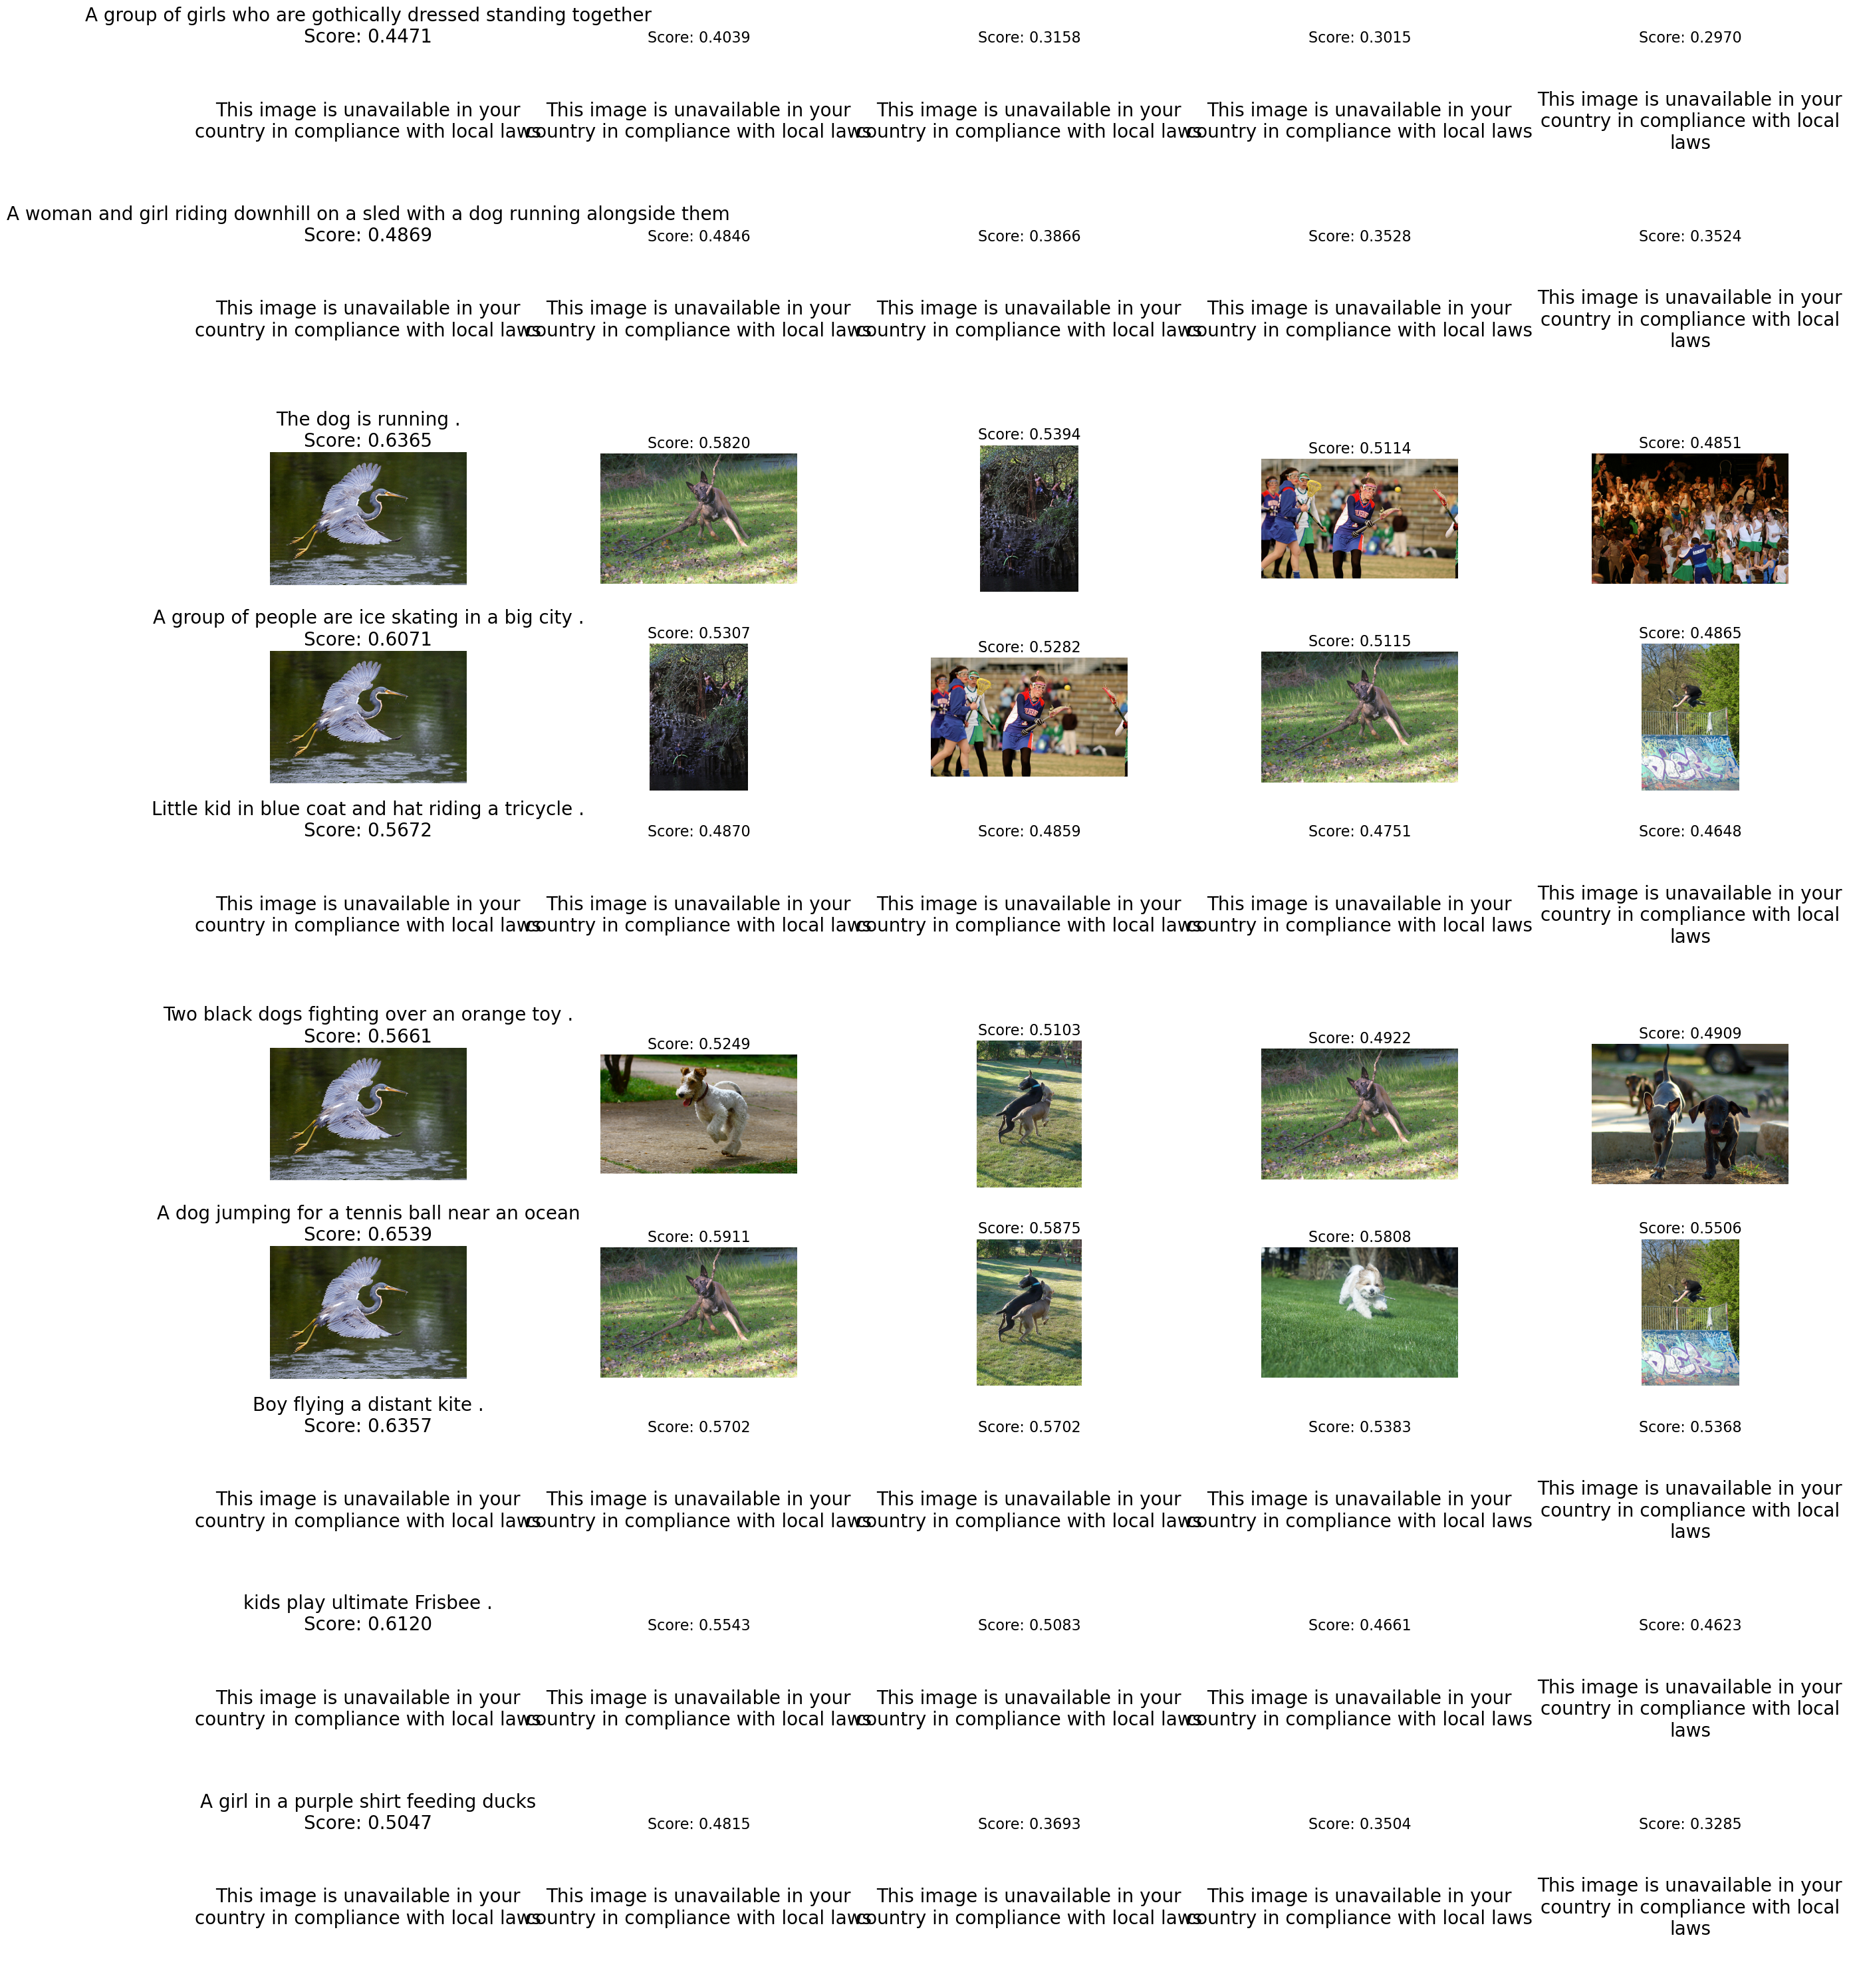

In [81]:
blocklist_keywords = [
    "boy", "boys",
    "girl", "girls",
    "young",
    "child", "children",
    "kid", "kids",
    "toddler", "toddlers",
    "baby", "babies",
    "infant", "infants",
    "newborn", "newborns",
    "teen", "teens",
    "teenager", "teenagers",
    "schoolboy", "schoolboys",
    "schoolgirl", "schoolgirls",
    "pupil", "pupils",
    "minor", "minors",
    "juvenile", "juveniles",
    "nursery", "nurseries",
    "diaper", "diapers",
    "pacifier", "pacifiers",
    "playground", "playgrounds"
]

unique_queries = test_images_df['query_text'].unique()

top_images = []
for query in unique_queries:
    query_df = test_images_df[test_images_df['query_text'] == query]
    top_5 = query_df.nlargest(5, 'final_score')

    for _, row in top_5.iterrows():
        top_images.append({
            'query_text': row['query_text'],
            'image': row['image'],
            'final_score': row['final_score']
        })

image_dir = r"C:\Users\artem\Desktop\Проект по изображениям\dsplus_integrated_project_4\to_upload\test_images"

plt.figure(figsize=(25, 30))

for i, result in enumerate(top_images):
    query_text = result['query_text']

    if any(blockword in query_text.lower() for blockword in blocklist_keywords):
        img = None
        disclaimer = "This image is unavailable in your country in compliance with local laws"

        wrapped_disclaimer = textwrap.fill(disclaimer, width=40)
    else:
        img_name = result['image']
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        disclaimer = None

    plt.subplot(len(top_images)//5, 5, i + 1)
    if img is not None:
        plt.imshow(img)
    else:
        plt.text(0.5, 0.5, wrapped_disclaimer, fontsize=20, ha='center', va='center', wrap=True)
    
    plt.axis('off')

    if i % 5 == 0:
        plt.title(f"{query_text}\nScore: {result['final_score']:.4f}", fontsize=20, ha='center')
    else:
        plt.title(f"Score: {result['final_score']:.4f}", fontsize=16)

plt.tight_layout()
plt.show()

- по запросу "The dog is running" сначала выведено изображение летящей птицы с оценкой 0.6365, а уже только потом изображение бегущей собаки с оценкой 0.582, а остальные изображение совсем нерелевантны, хоть и оценка достаточно высокая
- по запросу "A group of people are ice scating in a big city" отсутствуют изображения катания на льду и большого города, но снова изображена летящая птица и лишь третьим указана группа людей, а пятым указан человек, который "катится", но на скейте
- по запросу "Two black dogs fighting over an orange toy" снова выводится летящая птица, а уже после неё четыре изображения с собаками, среди которых только два с двумя собаками, но не видно оранжевую игрушку
- по запросу "A dog jumping for a tennis ball near an ocean" снова выводится летящая птица, а после неё три изображения с собаками, которые находятся в состоянии похожем на прыжок, но не видно теннисного мяча

**Промежуточные выводы:**
1. В ходе тестирования модели были проведены несколько ключевых этапов. В первую очередь, для проверки модели были выбраны 10 случайных текстовых описаний из тестового набора данных. Затем каждое описание было векторизовано и объединено с эмбеддингами изображений, что позволило сформировать общий вектор для дальнейшей обработки нейросетью. Модель выдала прогнозные оценки соответствия текстов и изображений, которые были занесены в датасет и использованы для выбора 5 наиболее релевантных изображений для каждого из запросов.
2. Для соблюдения юридических норм был внедрен механизм фильтрации, который проверяет текст на наличие стоп-слов, связанных с вредоносным контентом. В случае их обнаружения выводится дисклеймер, информирующий о недоступности изображений по законодательным причинам. Этот механизм был успешно реализован, и 6 из 10 запросов были заблокированы дисклеймером, что подтверждает его работоспособность.
3. По итогам тестирования, результаты модели показали, что для нескольких запросов она выдала нерелевантные изображения, что указывает на необходимость улучшения ее точности. Например, для запроса "The dog is running" модель сначала вывела изображение летящей птицы, которое, хотя и получило высокую оценку, не соответствовало запросу, а изображение бегущей собаки оказалось на втором месте. Подобные ошибки были также наблюдаемы для других запросов, таких как "A group of people are ice skating in a big city", где модель не смогла правильно интерпретировать описание и вместо катания на льду выдала изображение птицы. В других случаях, таких как запрос "Two black dogs fighting over an orange toy", модель в целом корректно идентифицировала собак, но не смогла отобразить оранжевую игрушку, что указывает на потребность в улучшении обработки специфичных объектов в изображениях.
4. В результате, несмотря на то, что модель продемонстрировала способности к извлечению релевантной информации из текстовых описаний, она нуждается в доработке, чтобы повысить точность и релевантность результатов поиска, особенно для более детализированных и специфичных запросов.

**Итоговые выводы:**
1. В ходе проекта было проведено детальное исследование данных. Загруженные датасеты, включая train_df, crowd_df, expert_df, test_queries_df и test_images_df, были проверены на полноту и корректность данных. Все данные оказались без пропусков и дубликатов, что подтвердило их пригодность для обучения и тестирования модели.
2. Для соблюдения юридических ограничений, связанных с обработкой изображений детей, был сформирован список стоп-слов. Эти слова включают такие термины, как "boy", "girl", "young", которые часто встречаются в текстах и могут попадать под юридические ограничения в зависимости от контекста. На основе этого списка была проведена очистка данных от описаний, содержащих эти слова, что позволило исключить записи, нарушающие законодательные нормы.
3. Векторизация изображений была выполнена с использованием предобученной модели ResNet-18, которая позволила извлечь эмбеддинги изображений размерностью 25088. Полносвязные слои были удалены, что исключило классификационные функции модели и позволило сосредоточиться исключительно на извлечении признаков из изображений. Этот этап был важным для обеспечения правильной обработки изображений.
4. Для текстов была использована модель BERT, что обеспечило качественное извлечение эмбеддингов длиной 768 токенов для каждого текстового запроса. Эта модель, благодаря своей предобученности на большом корпусе текстов, показала высокую точность в интерпретации текстовых запросов. Токенизация с использованием BertTokenizer позволила подготовить текст для подачи в модель BERT.
5. В результате, данные для обучения модели были подготовлены путем объединения эмбеддингов изображений и текстов, что позволило создать матрицу признаков размерностью 5558 на 25856 (включая как эмбеддинги изображений, так и текстов). В дальнейшем эти данные использовались для обучения моделей.
6. В процессе обучения были протестированы несколько моделей: Lasso Regression, Decision Tree и нейронная сеть. Наилучший результат показала модель нейронной сети с RMSE 0.2501, что подтверждает ее способность минимизировать ошибки в предсказаниях и обеспечить стабильную работу. Lasso Regression и Decision Tree показали худшие результаты, с RMSE 0.2676 и 0.3575 соответственно, что подтверждает преимущества нейронной сети в данной задаче.
7. В ходе тестирования модели было выбрано 10 случайных текстовых описаний из тестового набора. Для каждого описания были получены прогнозные оценки соответствия изображениям. Все изображения были векторизованы и объединены с эмбеддингами текстов, что позволило получить соответствующие прогнозы. На основе этих прогнозов для каждого запроса были выбраны 5 изображений с наибольшими значениями вероятности соответствия.
8. Для соблюдения юридических норм был внедрен механизм фильтрации, проверяющий наличие стоп-слов в текстах запросов. В случае их обнаружения выводился дисклеймер: "This image is unavailable in your country in compliance with local laws". Этот механизм был успешно протестирован, и 6 из 10 запросов были заблокированы дисклеймером, что подтверждает корректность работы фильтра.
9. В ходе тестирования было замечено, что модель выдавала нерелевантные изображения для некоторых запросов, что указывает на необходимость дальнейшего улучшения. Например, для запроса "The dog is running" модель сначала выдала изображение летящей птицы, а уже затем изображение бегущей собаки, что является ошибкой. Подобные ошибки были наблюдаемы и для других запросов, таких как "A group of people are ice skating in a big city", где модель неправильно интерпретировала запрос, выводя изображение птицы вместо людей, катающихся на льду. Тем не менее, на вторых местах выводились частично релевантные ихображение, что подтверждает возможную работоспособность модели.
10. Визуальное сравнение результатов поиска также подтвердило, что модель не всегда правильно интерпретирует контекст запросов, что требует доработки в части улучшения точности предсказаний, особенно для более сложных или специфичных запросов.
11. В результате тестирования и анализа работы модели можно сделать вывод, что проект по созданию системы поиска изображений по текстовому запросу вполне осуществим. Однако для полноценного внедрения в реальный продукт необходимо провести дополнительную настройку модели, повысить точность обработки запросов и улучшить контекстное восприятие.